# Knowledge Distillation

В этом ноутбуке содержится описание моих основных экспериментов по knowledge distillation. Здесь будут в основном графики и описания экспериментов, весь код для обучения и оценки качества моделей вынесен в отдельные модули. Проще всего запустить в Google Colab, тогда не нужно дополнительно устанавливать никаких зависимостей. Если хотите запустить решение на своей локальной машине, то следуйте инструкциям в README.md.

Выполните следующие две ячейки, если работаете в Google Colab:

In [1]:
! git clone https://github.com/stdereka/knowledge-distillation.git
! cp -r knowledge-distillation/dark_knowledge/ .
! cp -r knowledge-distillation/experiments/ .

Cloning into 'knowledge-distillation'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 245 (delta 117), reused 156 (delta 46), pack-reused 0
Receiving objects: 100% (245/245), 3.98 MiB | 3.58 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [2]:
import sys
sys.path.insert(1, "/content/knowledge-distillation")

## 1. Описание задачи

Метод KD был изначально предложен в [статье](https://arxiv.org/pdf/1503.02531.pdf). Для задачи многоклассовой классификации утверждается, что вероятности классов, предсказанные моделью-учителем, могут быть исползованы для обучения более простой модели-студента с меньшим числом параметров путём модификации лосса. Для многоклассовой классификации предлагается следующая функция потерь (здесь индекс $i$ пробегает по всем классам и по всем объектам):

\begin{equation}
E=-T^{2} (1 - \alpha) \sum_{i} \hat{y}_{i}(\mathbf{x} \mid T) \log y_{i}(\mathbf{x} \mid T)- \alpha\sum_{i} \bar{y}_{i} \log y_{i}(\mathbf{x} \mid 1)
\end{equation}

где $y_{i}(\mathbf{x} \mid T)=\frac{e^{\frac{z_{i}(\mathbf{x})}{T}}}{\sum_{j} e^{\frac{z_{j}(\mathrm{x})}{T}}}$ - предсказания модели при температуре $T$ (она требуется для того, чтобы предсказания сильнее отличались от 0 и 1 и несли больше информации), $\hat{y}_{i}(\mathbf{x} \mid T)$ - "мягкие" метки учителя, $\bar{y}_{i}$ - "жёсткие" groundtruth метки. $\alpha$ - весовой параметр для регулирования вклада жёсткой и мягкой кроссэнтропий в градиент. Авторы статьи пишут, что всё должно хорошо работать при $\alpha$ близком к нулю.


## 2. Датасет Imagewoof

Imagewoof - датасет из изображений собак, относящимся к разным породам. На нём можно решать задачу многоклассовой классификации. Я выбрал его для экспериментов по нескольким причинам. Во-первых, классы трудноразделимы, слишком простые модели не смогут эффективно решить задачи, поэтому есть шансы пронаблюдать эффекты KD на более сложных моделях. Во-вторых, по Imagewoof не так много публикаций на тему KD, это значит, что результаты экспериментов мне заранее не известны.

Сначала я хотел начать с воспроизведения результатов статьи на датасете MNIST, но это уже сделали за меня, например, [тут](https://github.com/peterliht/knowledge-distillation-pytorch). Я решил сразу начать со своих экспериментов на более сложной задаче.

## 3. Общая схема эксперимента

1. **Выбрать и обучить модель-учитель.** Эта модель должна содержать большое число параметров (возможно, даже избыточное) и быть сильно регуляризована (в задачах CV подойдут сильные дропауты и аугментации), а также выдавать очень хорошее (по меркам задачи) качество на отложенной выборке.

2. **Обучение и оценка качества модели-студента с Distillation Loss.** Модель-студент содержит ощутимо меньше параметров, чем модель-учитель и никак не регуляризована. На этом этапе можно играть с параметрами $\alpha$, $T$, размером обучающей выборки и много чем ещё.

3. **Обучить модель-студента без помощи учителя.** Здесь очень важно, чтобы процесс обучения отличался только лоссом, это позволит исключить вклад всех прочих факторов.

4. **Сравнить метрики в пунктах 2 и 3**, построить выводы об эффективности KD в текущем эксперименте.

Из бесплатных ресурсов в моём распоряженни только Google Colab, это очень неудобно с точки зрения разработки и воспроизводимости результатов, но я смог найти выход и прийти к следующей схеме. Код пишется и тестируется локально на моём компьютере. Когда всё готово, ноутбук с параметрами отправляется на Google Сolab, подтягивает код с GitHub и выполняет эксперимент. Затем код, результаты и параметры сохраняются в одном коммите, это позволяет при необходимости вернуться и воспроизвести эксперимент.

## 4. Демонстрационный эксперимент

В этой части я проведу эксперимент согласно пункту 3.

In [3]:
# Load data
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
! tar zxf imagewoof2-320.tgz
# Check GPU
! nvidia-smi

--2020-09-23 15:34:47--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.179.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.179.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328288506 (313M) [application/x-tar]
Saving to: ‘imagewoof2-320.tgz’

imagewoof2-320.tgz  100%[===================>] 313.08M  16.6MB/s    in 21s     

2020-09-23 15:35:08 (15.2 MB/s) - ‘imagewoof2-320.tgz’ saved [328288506/328288506]

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
import torch
import random
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import os
from training import train, predict, DistillationLoss
from models import *
from datasets import ImageDataset
from itertools import product

In [5]:
"""
Define globals and seed whatever I can seed
"""
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Training on CPU')
    DEVICE = torch.device("cpu")
else:
    print('Training on GPU')
    DEVICE = torch.device("cuda")

SEED = 0
seed_everything(SEED)

TRAIN_DIR = Path('./imagewoof2-320/train')
TEST_DIR = Path('./imagewoof2-320/val')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))
test_files = sorted(list(TEST_DIR.rglob('*.JPEG')))

train_val_labels = [path.parent.name for path in train_val_files]
LABEL_ENCODER = LabelEncoder()
LABEL_ENCODER.fit(train_val_labels)

N_CLASSES = LABEL_ENCODER.classes_.shape[0]

Training on CPU


In [6]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.flatten()

    ax[0].plot(history[:, 0], label="Train")
    ax[0].plot(history[:, 2], label="Val")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history[:, 1], label="Train")
    ax[1].plot(history[:, 3], label="Val")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    ax[1].grid()

    plt.show()

### 4.1. Выбор и обучение модели-учителя

Учитель - Resnet101. Я добавил два скрытых полносвязных слоя по 2048 юнитов. Такая модель явно избыточна, очень быстро переобучается и требует адский дропаут ($p=0.95$), чтобы не переобучиться и показать хорошие результаты на валидационной выборке. При обучении этой модели я также задействовал сильные аугментации.

Для дальнейших экспериментов (например, с размером обучающей выборки для модели-студента) могут понадобиться предсказания учителя на всей обучающей выборке. Чтобы не допустить утечки данных я использую 1x4 кроссвалидацию со стратификацией по классам, итоговые предсказания - это out-of-fold предсказания моделей-учителей, соответствующих разным фолдам. Таким образом, для получения предсказаний на всём датасете нужно обучить учителя целых 4 раза, зато после этого можно надолго о нём забыть и заняться непосредственно KD.

In [ ]:
N_SPLITS = 4

seed_everything(SEED)

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
ground = np.array(ImageDataset(train_val_files, LABEL_ENCODER).labels)

# Array for storing OOF logits
oof_logits = np.empty((len(train_val_files), N_CLASSES), float)

labels = LABEL_ENCODER.transform(train_val_labels)

test_dataset = ImageDataset(test_files, LABEL_ENCODER)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

# Array for storing test dataset logits
test_logits = np.zeros((len(test_dataset), N_CLASSES), float)

for fold, (train_idx, val_idx) in enumerate(cv.split(train_val_files, labels)):
    print('Training on fold', fold + 1)

    val_dataset = ImageDataset(np.array(train_val_files)[val_idx], LABEL_ENCODER)
    train_dataset = ImageDataset(np.array(train_val_files)[train_idx], LABEL_ENCODER, augs=True)
    
    model = resnet101_teacher(N_CLASSES, DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=0.0003)
    criterion = nn.CrossEntropyLoss()
    history = train(train_dataset, val_dataset, model=model, epochs=20,
                              batch_size=64, device=DEVICE, opt=opt, criterion=criterion)
    
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)
    labels_val = ground[val_idx]
    
    logits_val = predict(model, val_loader, DEVICE, logit=True)
    oof_logits[val_idx] = logits_val
    preds_val = np.argmax(logits_val, axis=1)
    
    # Prediction on test set is an average of N_SPLITS models
    test_logits += predict(model, test_loader, DEVICE, logit=True)/N_SPLITS
    
    print(f'Fold {fold + 1} accuracy score:', accuracy_score(labels_val, preds_val))

oof_preds = np.argmax(oof_logits, axis=1)
print('OOF accuracy score:', accuracy_score(ground, oof_preds))

# Save results
os.makedirs("./dark_knowledge", exist_ok=True)
np.save("./dark_knowledge/resnet101_train_imagewoof.npy", oof_logits)
np.save("./dark_knowledge/resnet101_test_imagewoof.npy", test_logits)

Training on fold 1


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Epoch: 1, train_loss: 2.7788, val_loss: 2.2557, train_acc: 0.1169, val_acc: 0.4945
Epoch: 2, train_loss: 1.4853, val_loss: 0.3969, train_acc: 0.8097, val_acc: 0.9278
Epoch: 3, train_loss: 0.3147, val_loss: 0.1817, train_acc: 0.9170, val_acc: 0.9508
Epoch: 4, train_loss: 0.2246, val_loss: 0.1467, train_acc: 0.9279, val_acc: 0.9526
Epoch: 5, train_loss: 0.2063, val_loss: 0.1502, train_acc: 0.9334, val_acc: 0.9504
Epoch: 6, train_loss: 0.1927, val_loss: 0.1605, train_acc: 0.9362, val_acc: 0.9504
Epoch: 7, train_loss: 0.1982, val_loss: 0.1504, train_acc: 0.9341, val_acc: 0.9499
Epoch: 8, train_loss: 0.1852, val_loss: 0.1447, train_acc: 0.9387, val_acc: 0.9521
Epoch: 9, train_loss: 0.1910, val_loss: 0.1451, train_acc: 0.9400, val_acc: 0.9539
Epoch: 10, train_loss: 0.1836, val_loss: 0.1380, train_acc: 0.9387, val_acc: 0.9544
Epoch: 11, train_loss: 0.1727, val_loss: 0.1329, train_acc: 0.9402, val_acc: 0.9601
Epoch: 12, train_loss: 0.1752, val_loss: 0.1386, train_acc: 0.9430, val_acc: 0.9530
E

### 4.2. Модель-студент. Дистилляция знаний

Студент - Resnet18 с двумя дополнительными скрытыми полносвязными слоями по 128 юнитов. При обучении этой модели я не задействую ни дропауты, ни аугментации. Спойлер: это необходимо, потому что эффект от KD в этой задаче очень маленький, и чтобы его обнаружить, нужно исключить все прочие факторы, влияющие на качество модели.

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


83466 (of 11259978) trainable params


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 1, train_loss: 1.3721, val_loss: 0.9477, train_acc: 0.6088, val_acc: 0.8338
Epoch: 2, train_loss: 0.6215, val_loss: 0.3804, train_acc: 0.8690, val_acc: 0.8839
Epoch: 3, train_loss: 0.2938, val_loss: 0.2322, train_acc: 0.9003, val_acc: 0.8979
Epoch: 4, train_loss: 0.2055, val_loss: 0.1843, train_acc: 0.9170, val_acc: 0.9084
Epoch: 5, train_loss: 0.1738, val_loss: 0.1637, train_acc: 0.9233, val_acc: 0.9137
Epoch: 6, train_loss: 0.1582, val_loss: 0.1518, train_acc: 0.9301, val_acc: 0.9216
Epoch: 7, train_loss: 0.1491, val_loss: 0.1450, train_acc: 0.9337, val_acc: 0.9267
Epoch: 8, train_loss: 0.1453, val_loss: 0.1417, train_acc: 0.9343, val_acc: 0.9211
Epoch: 9, train_loss: 0.1380, val_loss: 0.1368, train_acc: 0.9382, val_acc: 0.9287
Epoch: 10, train_loss: 0.1336, val_loss: 0.1332, train_acc: 0.9396, val_acc: 0.9277
Epoch: 11, train_loss: 0.1303, val_loss: 0.1303, train_acc: 0.9405, val_acc: 0.9275
Epoch: 12, train_loss: 0.1274, val_loss: 0.1296, train_acc: 0.9408, val_acc: 0.9310
E

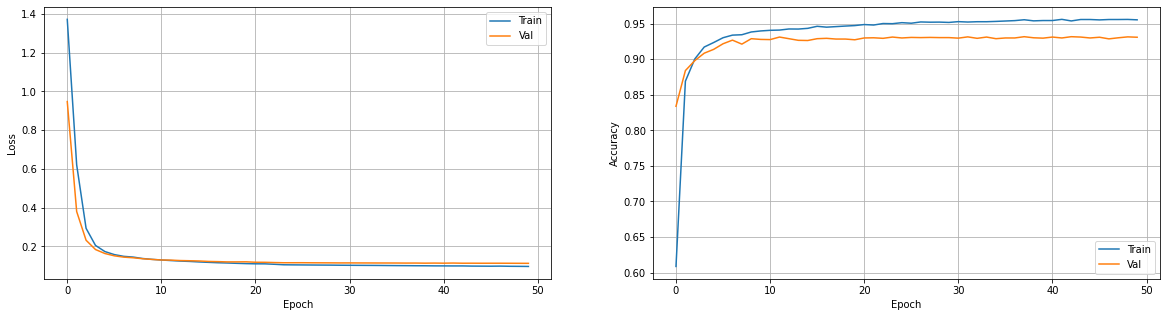

In [ ]:
os.makedirs("./experiments/hyperparams", exist_ok=True)
seed_everything(SEED)

resnet18 = resnet18_student2(N_CLASSES, DEVICE)
trainable = get_number_of_params(resnet18, trainable=True)
total = get_number_of_params(resnet18, trainable=False)
print(f"{trainable} (of {total}) trainable params")
train_dataset = ImageDataset(train_val_files, LABEL_ENCODER, teacher_labels="./dark_knowledge/resnet101_train_imagewoof.npy")
test_dataset = ImageDataset(test_files, LABEL_ENCODER, teacher_labels="./dark_knowledge/resnet101_test_imagewoof.npy")
opt = torch.optim.Adam(resnet18.parameters(), lr=0.0001)
criterion = DistillationLoss(alpha=0.1, temperature=4.0)
history_resnet18 = train(train_dataset, test_dataset, resnet18, 50, 64, DEVICE, opt, criterion)
plot_training_history(history_resnet18)
np.save("./experiments/hyperparams/history_resnet18_T_4.0_alpha_0.1.npy", history_resnet18)

### 4.3. Обучение без помощи учителя и сравнение результатов

Повторим процедуру предыдущего пункта, только без использования меток модели-учителя.

83466 (of 11259978) trainable params
Epoch: 1, train_loss: 1.0286, val_loss: 0.3848, train_acc: 0.7910, val_acc: 0.8865
Epoch: 2, train_loss: 0.3042, val_loss: 0.2811, train_acc: 0.9128, val_acc: 0.9160
Epoch: 3, train_loss: 0.2299, val_loss: 0.2711, train_acc: 0.9325, val_acc: 0.9119
Epoch: 4, train_loss: 0.2032, val_loss: 0.2466, train_acc: 0.9385, val_acc: 0.9247
Epoch: 5, train_loss: 0.1877, val_loss: 0.2358, train_acc: 0.9418, val_acc: 0.9262
Epoch: 6, train_loss: 0.1754, val_loss: 0.2392, train_acc: 0.9433, val_acc: 0.9254
Epoch: 7, train_loss: 0.1646, val_loss: 0.2611, train_acc: 0.9463, val_acc: 0.9140
Epoch: 8, train_loss: 0.1880, val_loss: 0.2297, train_acc: 0.9407, val_acc: 0.9282
Epoch: 9, train_loss: 0.1503, val_loss: 0.2324, train_acc: 0.9531, val_acc: 0.9252
Epoch: 10, train_loss: 0.1371, val_loss: 0.2362, train_acc: 0.9571, val_acc: 0.9247
Epoch: 11, train_loss: 0.1331, val_loss: 0.2359, train_acc: 0.9573, val_acc: 0.9257
Epoch: 12, train_loss: 0.1312, val_loss: 0.2384,

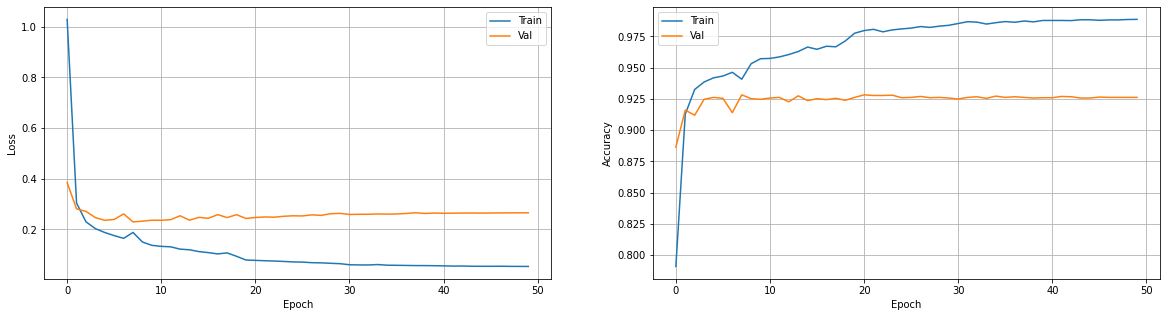

In [ ]:
os.makedirs("./experiments/hyperparams", exist_ok=True)
seed_everything(SEED)

resnet18 = resnet18_student2(N_CLASSES, DEVICE)
trainable = get_number_of_params(resnet18, trainable=True)
total = get_number_of_params(resnet18, trainable=False)
print(f"{trainable} (of {total}) trainable params")
train_dataset = ImageDataset(train_val_files, LABEL_ENCODER)
test_dataset = ImageDataset(test_files, LABEL_ENCODER)
opt = torch.optim.Adam(resnet18.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
history_resnet18_no_teacher = train(train_dataset, test_dataset, resnet18, 50, 64, DEVICE, opt, criterion)
plot_training_history(history_resnet18_no_teacher)
np.save(f"./experiments/hyperparams/history_resnet18_no_teacher.npy", history_resnet18_no_teacher)

Построим графики accuracy моделей на тестовой выборке.

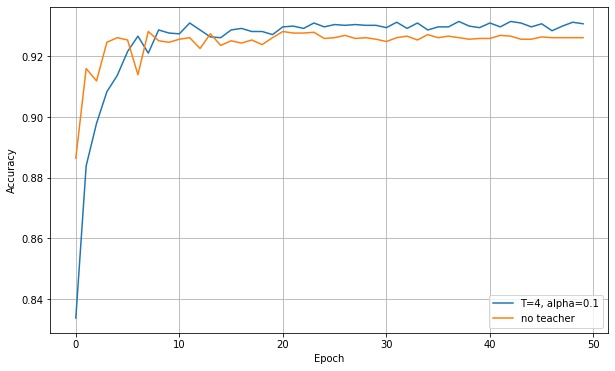

In [ ]:
history_resnet18_teacher = np.load("./experiments/hyperparams/history_resnet18_T_4.0_alpha_0.1.npy")
history_resnet18_no_teacher = np.load("./experiments/hyperparams/history_resnet18_no_teacher.npy")
plt.figure(figsize=(10, 6))
plt.plot(history_resnet18[:, 3], label = "T=4, alpha=0.1")
plt.plot(history_resnet18_no_teacher[:, 3], label = "no teacher")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Примерно к 30-40 эпохам обе модели выходят на плато. Судя по всему, KD дал небольшой прирост в метрике. Результат, конечно, не очень впечатляет. Можно сравнивать финальное качество, усредняя результаты последних 20-ти эпох.

In [ ]:
print("KD: {:.4f}, no teacher: {:.4f}".format(history_resnet18_teacher[-20:, 3].mean(), history_resnet18_no_teacher[-20:, 3].mean()))

KD: 0.9302, no teacher: 0.9262


## 5. Эксперимент с разными температурами

Я провёл серию аналогичных экспериментов для $\alpha = 0.1$ и $T = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]$.

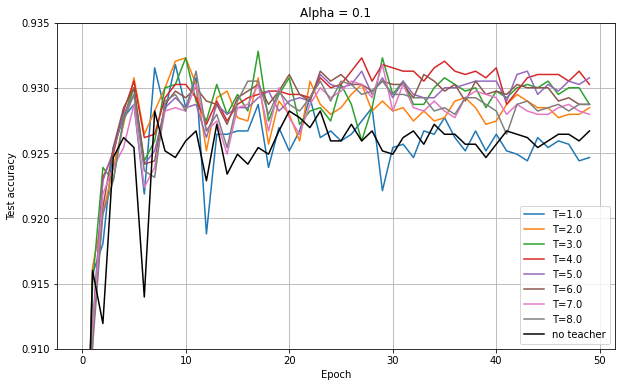

In [17]:
temperatures = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
means = []

plt.figure(figsize=(10, 6))
for t in temperatures:
    history = np.load(f"/content/experiments/hyperparams/history_resnet18_T_{t}_alpha_0.1.npy")
    plt.plot(history[:, 3], label = f"T={t}")
    means.append(history[-20:, 3].mean())

history_no_teacher = np.load("./experiments/hyperparams/history_resnet18_no_teacher.npy")
mean_no_teacher = history_no_teacher[-20:, 3].mean()
plt.plot(history_no_teacher[:, 3], label = "no teacher", color="black")

plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.title("Alpha = 0.1")
plt.ylim(0.91, 0.935)
plt.legend()
plt.grid()
plt.show()

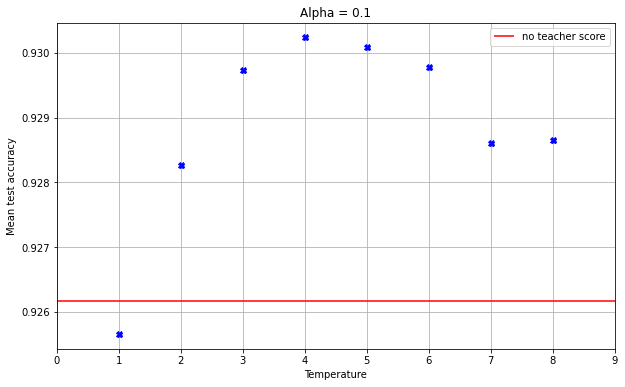

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, means, "bX")
plt.hlines(mean_no_teacher, 0, 9, "red", label="no teacher score")
plt.xlim(0, 9)
plt.xlabel("Temperature")
plt.ylabel("Mean test accuracy")
plt.title("Alpha = 0.1")
plt.legend()
plt.grid()

В этом эксперименто почти все значения температуры дали небольшой прирост в метрике. Оптимальная температура находится где-то в диапазоне от 3 до 6. Эффект от KD получился совсем небольшим. В [этом](https://github.com/peterliht/knowledge-distillation-pytorch#results-shallow-and-deep-distillation) репозитории проводились похожие эксперименты для задач Computer Vision (на датасете CIFAR-10), и улучшение качества тоже было незначительным.

## 6. Влияние размера обучающей выборки на качество дистилляции

Интересно посмотреть, как будут обучаться модели при уменьшении размера обучающей выборки. Я взял доли от исходного датасета $p = [0.01, 0.05, 0.1]$. 

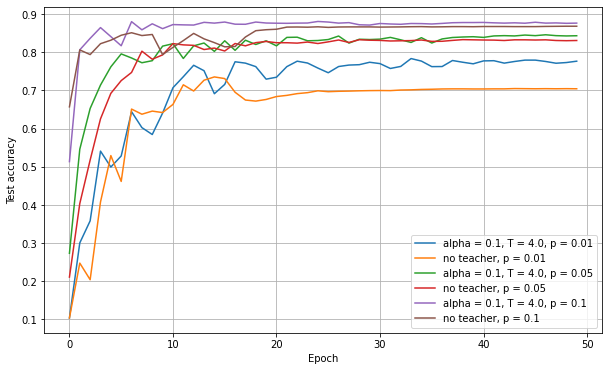

In [15]:
ps = [0.01, 0.05, 0.1]

plt.figure(figsize=(10, 6))
for p in ps:
    history = np.load(f"./experiments/subset/history_resnet18_T_4.0_alpha_0.1_p_{p}.npy")
    plt.plot(history[:, 3], label = f"alpha = 0.1, T = 4.0, p = {p}")

    history_no_teacher = np.load(f"./experiments/subset/history_resnet18_no_teacher_p_{p}.npy")
    plt.plot(history_no_teacher[:, 3], label = f"no teacher, p = {p}")

plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()
plt.grid()
plt.show()

KD лучше всего показал себя в самом экстремальном случае, когда обучение велось на $< 100$ картинках. При увеличении обучающей выборки модель получает возможность хорошо генерализоваться и эффект от KD вносит уже меньший вклад в финальное качество.

## 7. Промежуточные выводы

Результаты, которые я получил в экспериментах, показывают незначительное улучшение модели-студента при использовании KD. Этого всё ещё недостаточно для того, чтобы применять метод в реальных задачах. Тем не менее я бы хотел изучить работу knowledge distillation совместно с другими методами сжатия нейросетей. У меня есть гипотеза, что он может принести пользу совместно с [pruning](https://arxiv.org/pdf/1611.06440.pdf), где может быть задействован на стадии fine-tuning (возможно, получится снизить потерю качества после итерации pruning). Такие исследования уже [проводились](https://arxiv.org/pdf/1801.05787.pdf), и есть даже неплохие результаты.